In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"})
import numpy as np
from data.material import HARDENING, MATERIALS, Y0
from models.MLP_incr import load_model, MLP_incr
from train import prepare_data
import os.path as osp
import os
import torch
import json

def plot_response(eps, sig_true, sig_pred, t, plot_iter=[((0,1),'black')]):
    fig = plt.figure(figsize=(8, 4),dpi=250)
    gs = GridSpec(2, 2, height_ratios=[1, 1])
    # fig.suptitle(r'', fontsize=18)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    N = eps.shape[0]

    for interval, color in plot_iter:
        
        start = int(interval[0]*N)
        end   = int(interval[1]*N)

        ax1.plot(eps[start:end],sig_pred[start:end],c=color,lw=1.5)
        ax1.plot(eps[start:end],sig_true[start:end],c=color,lw=2,alpha=0.3)
        ax2.plot(t[start:end],eps[start:end],c=color,lw=1.5)
        ax3.plot(t[start:end],sig_pred[start:end],c=color,lw=1.5)
        ax3.plot(t[start:end],sig_true[start:end],c=color,lw=2,alpha=0.3)

    #for ax_i in [ax1,ax2,ax3]:
    #    ax_i.set_xticks([])  # Remove x-axis numbers
    #    ax_i.set_yticks([])
    ax1.set_xlabel(r'$\varepsilon$', fontsize=18)
    ax2.set_xlabel(r'$t$', fontsize=18)
    ax3.set_xlabel(r'$t$', fontsize=18)
    ax1.set_ylabel(r'$\sigma$', fontsize=18)
    ax2.set_ylabel(r'$\varepsilon$', fontsize=18)
    ax3.set_ylabel(r'$\sigma$', fontsize=18)

# Eval of set of models

In [2]:
k,p,q = 7,8,3
train_session = f'MLP_incr_rand_{k}-{p}-{q}'

base_path = osp.join('metrics','models',train_session)

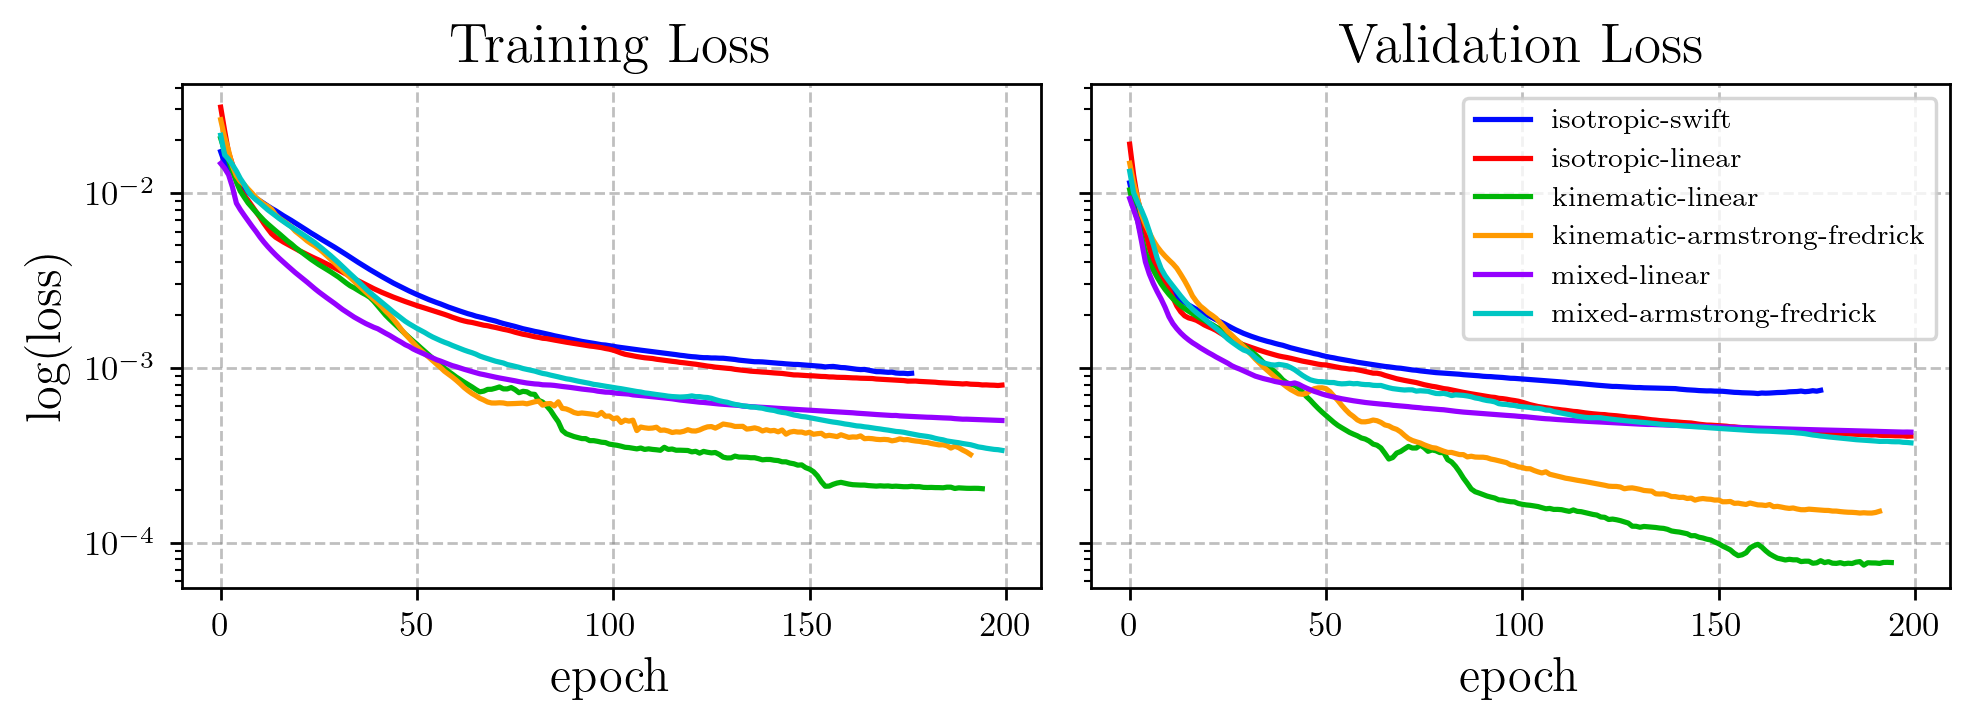

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3),dpi=250,sharey=True)
for name in MATERIALS:
    model_path = osp.join(base_path,name)
    if osp.exists(model_path):
        model = load_model(osp.join(model_path,'model.pth'))
        ax[0].semilogy(model.train_losses, label=name, color=MATERIALS[name]['color'], lw=1.5)
        ax[1].semilogy(model.val_losses, label=name, color=MATERIALS[name]['color'], lw=1.5)

ax[0].set_title('Training Loss',fontsize=16)
ax[1].set_title('Validation Loss',fontsize=16)
ax[0].set_ylabel('log(loss)',fontsize=14)
ax[0].set_xlabel('epoch',fontsize=14)
ax[1].set_xlabel('epoch',fontsize=14)
ax[0].grid(ls='--',color='gray',alpha=0.5)
ax[1].grid(ls='--',color='gray',alpha=0.5)
ax[1].legend(loc='upper right', fontsize=8, ncol=1)
plt.tight_layout()
plt.savefig(osp.join(base_path,'convergence.png'))
plt.show()

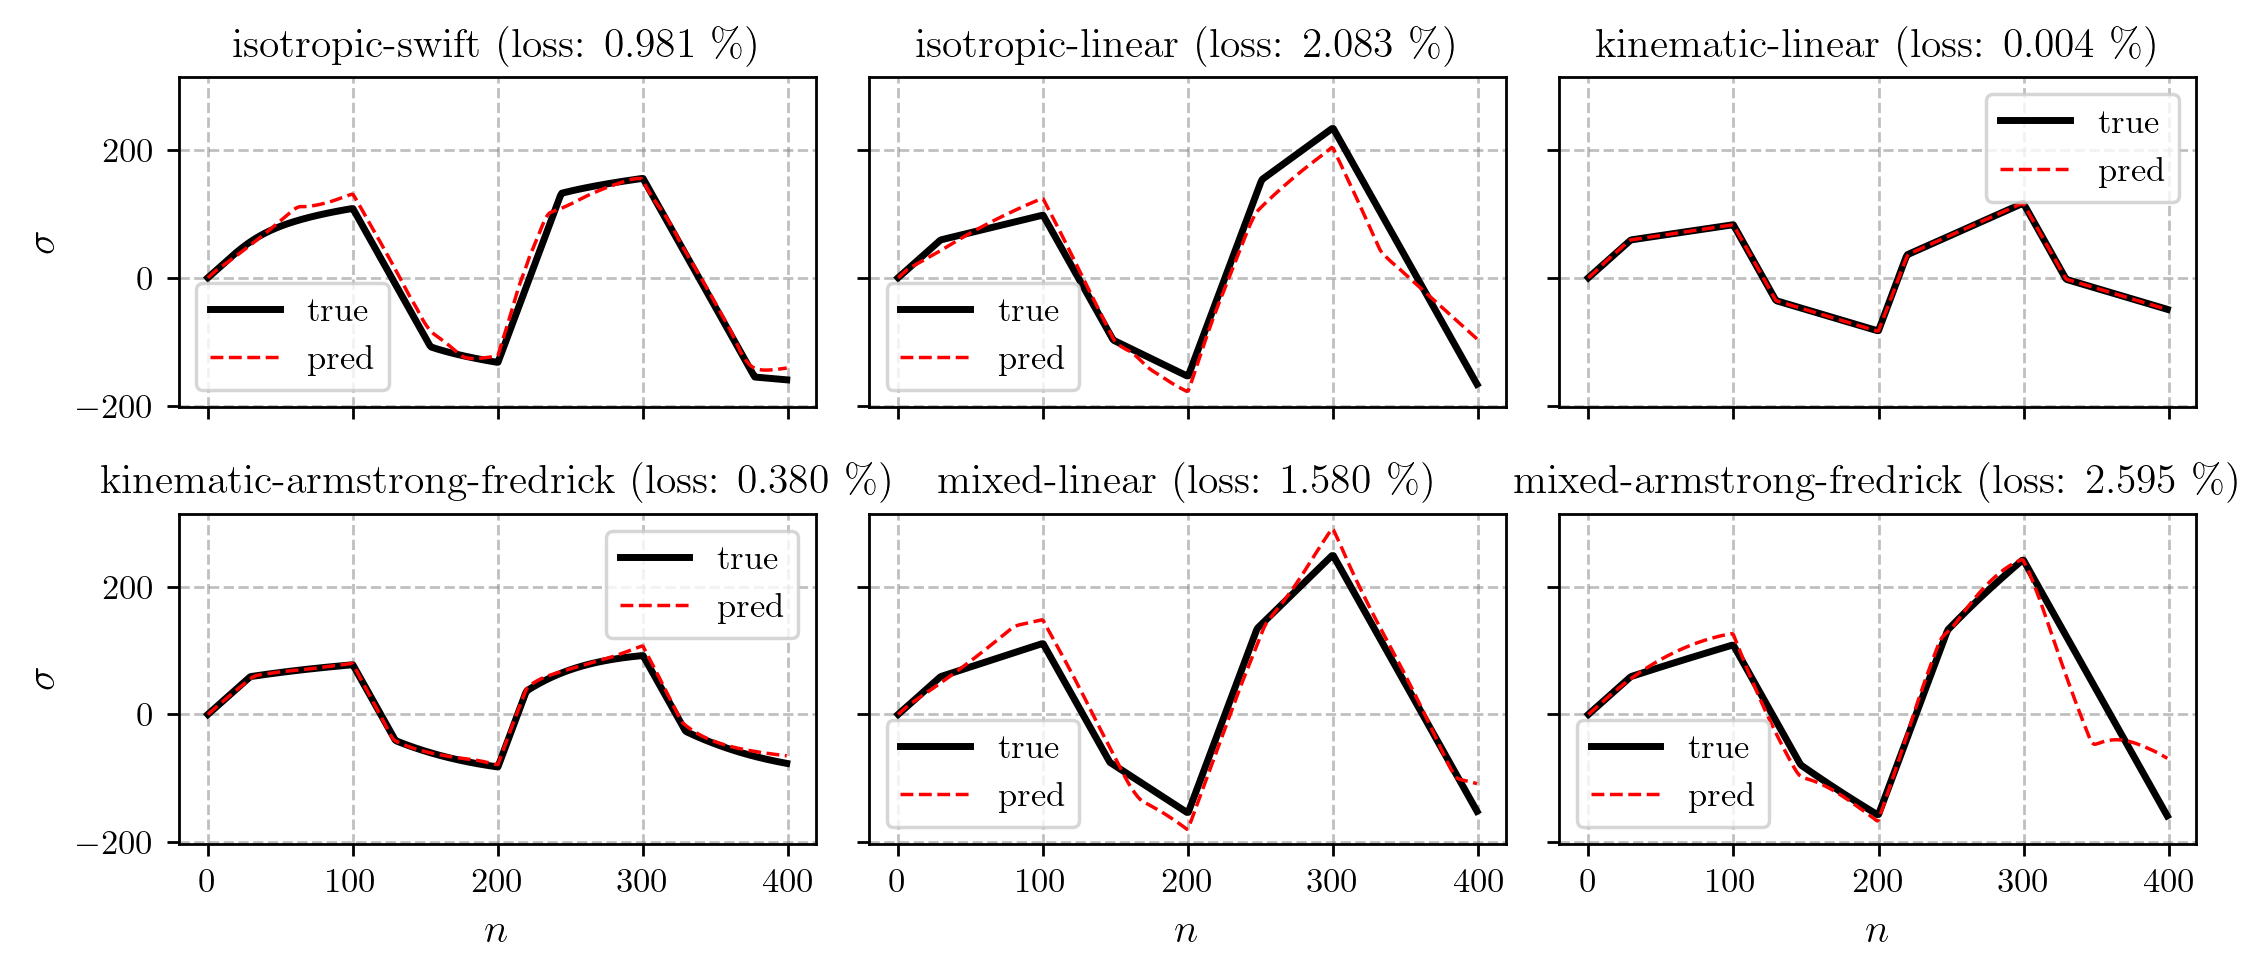

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(9, 4),dpi=250,sharex=True,sharey=True)
for i in range(ax.shape[1]): ax[-1,i].set_xlabel(r'$n$',fontsize=12)
for i in range(ax.shape[0]): ax[i,0].set_ylabel(r'$\sigma$',fontsize=12)

ax = ax.flatten()
score_json = {}
for i,name in enumerate(MATERIALS):
    model_path = osp.join(base_path,name)
    if osp.exists(model_path):
        model = load_model(osp.join(model_path,'model.pth'))

        
        Y,U = prepare_data(name)
        _, _, y_test, y_bench = Y
        _, _, u_test, u_bench = U

        error_bench = model.evaluate(y_bench,u_bench)
        error_test = model.evaluate(y_test, u_test)
        
        score_json[name] = {
            'benchmark_mse': float(error_bench),
            'test_mse': float(error_test),
        }

        y_pred = model.predict(y_bench[:,:k,0],u_bench[:,:,0])
        ax[i].plot(y_bench[0,:,0]/1e6, label='true', color='black', lw=2)
        ax[i].plot(y_pred[0].detach().numpy()/1e6, label='pred', color='red', lw=1,ls='--')
        ax[i].legend()
    
    
    ax[i].grid(ls='--',color='gray',alpha=0.5)
    ax[i].set_title(f'{name} (loss: {error_bench*100:.3f} \\%)')

plt.tight_layout()
plt.savefig(osp.join(base_path,'benchmark-eval.png'))
with open(osp.join(base_path,'scores.json'),'w') as file:
    json.dump(score_json,file)
plt.show()

# Check the AUTOREGRESSIVITY and TIME-SCALE INVARIANCE (OPTIONAL)

In [9]:
k,p,q = 7,8,3
train_session = f'MLP_incr_rand_{k}-{p}-{q}'
name =  'isotropic-swift'

model_path = osp.join('metrics','models',train_session,name)

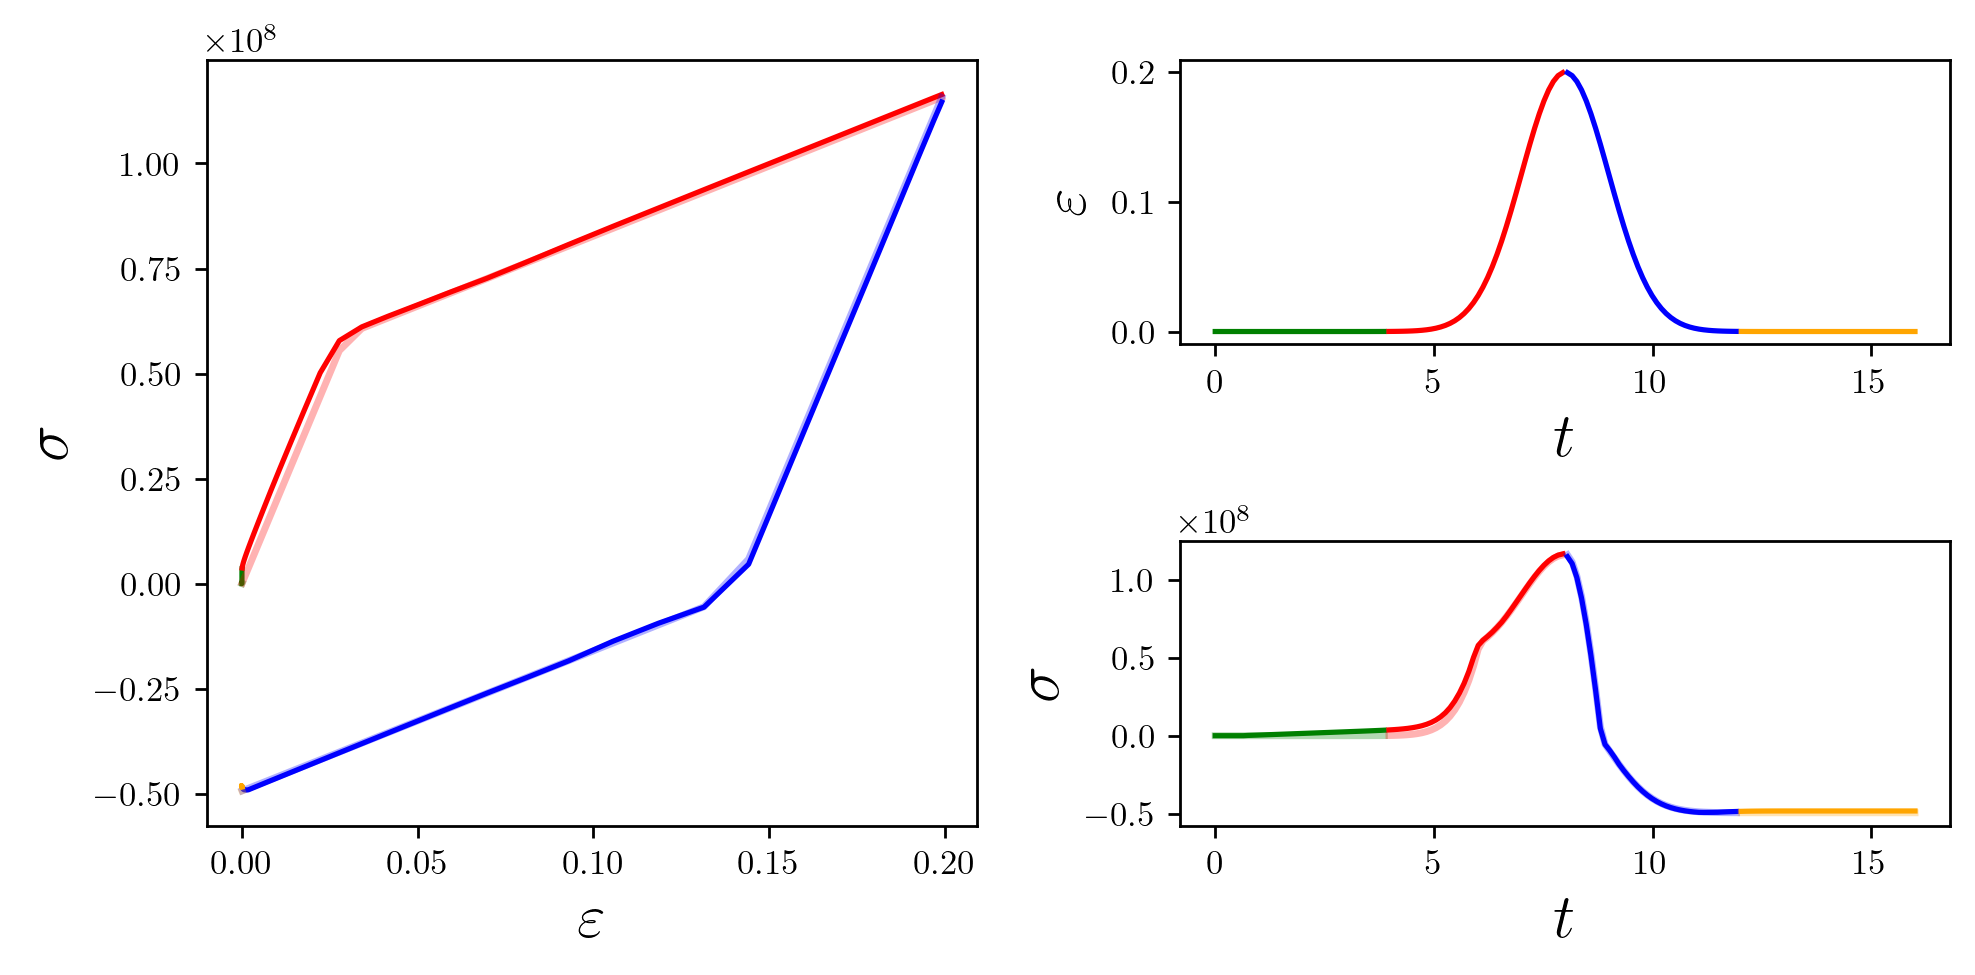

In [ ]:
N = 150

# input signal
mu, sigma = 0, 1
t = np.linspace(mu - 8*sigma, mu + 8*sigma, N) 
eps = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((t - mu) / sigma)**2)/2
t -= mu - 8*sigma

# True response
mat = MATERIALS[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

# pred response
model = load_model(osp.join(model_path, f'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(
    eps, 
    sig_true, 
    sig_pred, 
    t,     
    plot_iter =  [
    ((0/4,1/4),'green'),
    ((1/4,2/4),'red'),
    ((2/4,3/4),'blue'),
    ((3/4,4/4),'orange'),
])
plt.tight_layout()
plt.savefig(osp.join(model_path,f'gauss_N={N}.png'))
plt.show()

In [15]:
np.save('data/bottlenecks/impulse.npy',eps.reshape(1,-1))

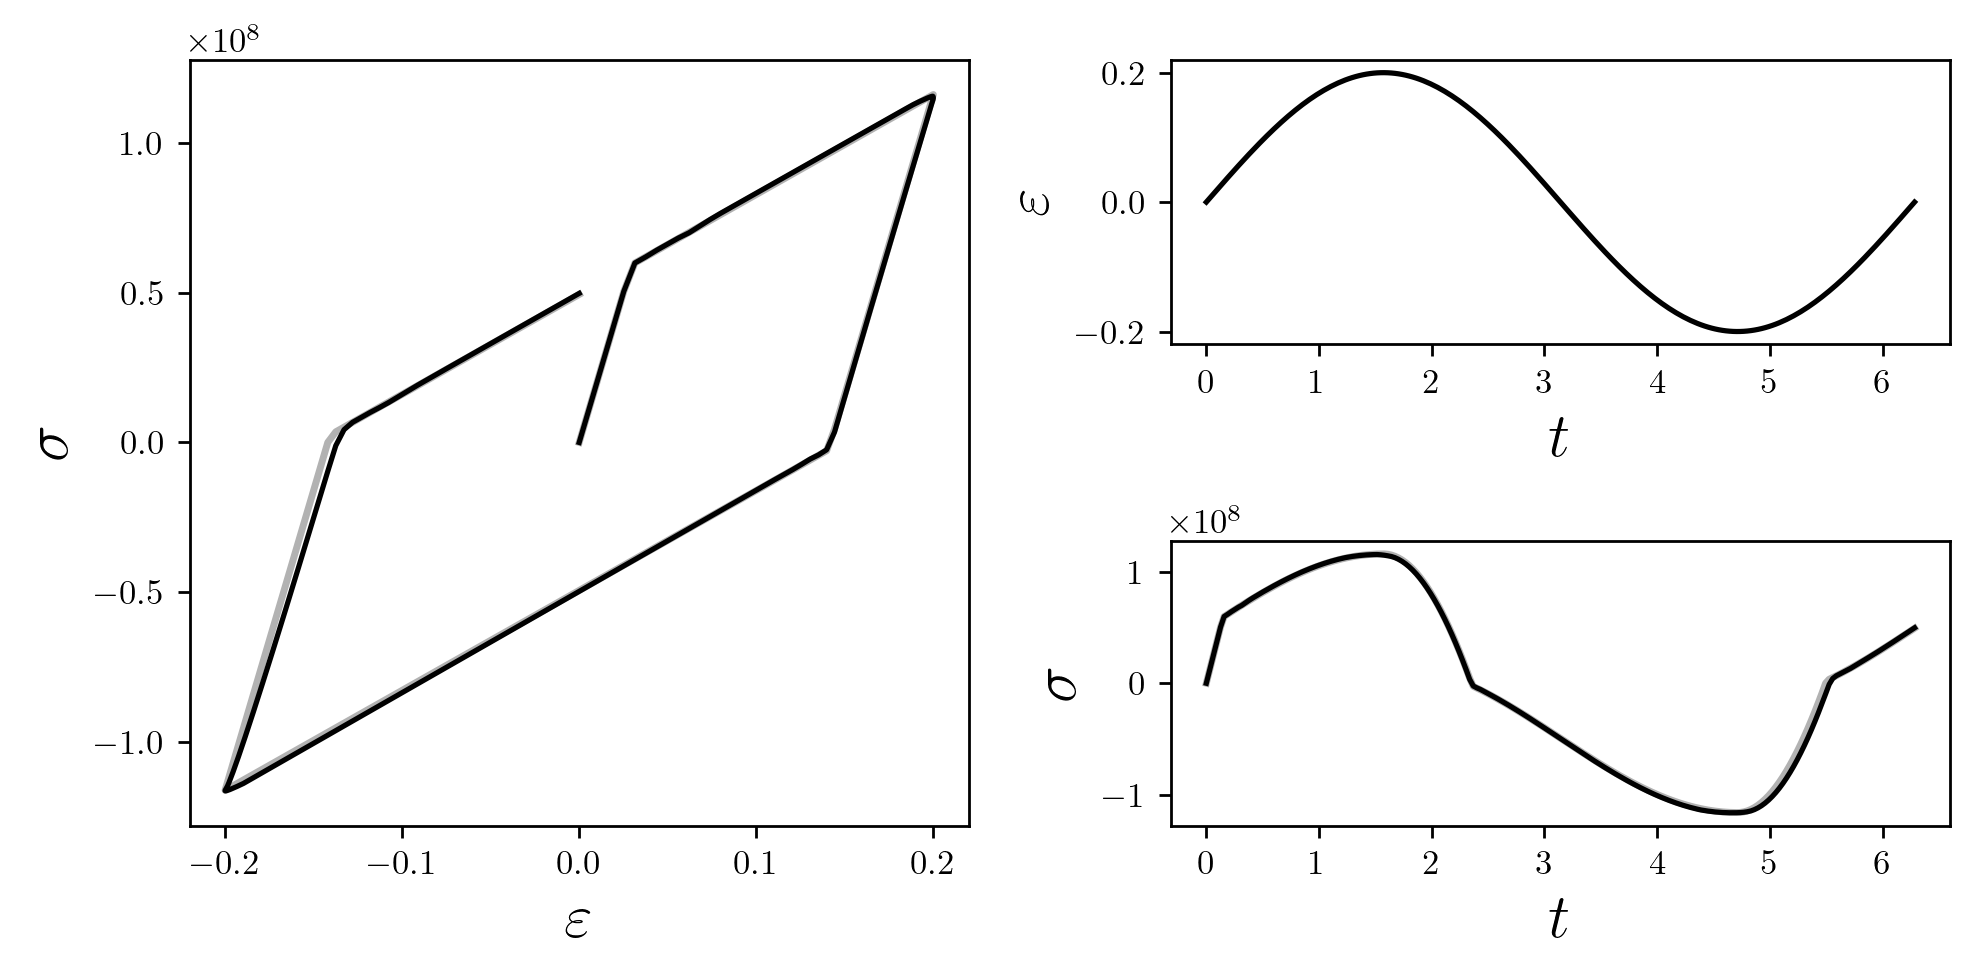

In [ ]:
N = 200
 
t = np.linspace(0, 2*np.pi, N)
eps = np.sin(t) * 0.2

mat = MATERIALS[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(
    eps, 
    sig_true, 
    sig_pred, 
    t,     
)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'sin1_N={N}.png'))
plt.show()

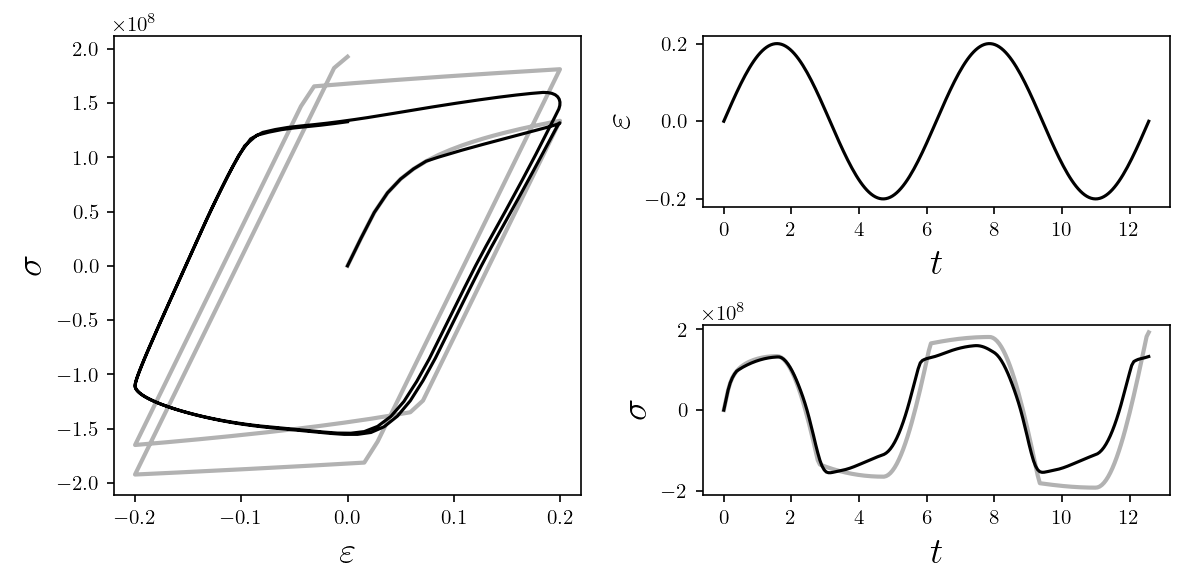

In [ ]:
N = 200
 
t = np.linspace(0, 4*np.pi, N)
eps = np.sin(t) * 0.2

mat = MATERIALS[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(eps, sig_true, sig_pred, t)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'sin2_N={N}.png'))
plt.show()

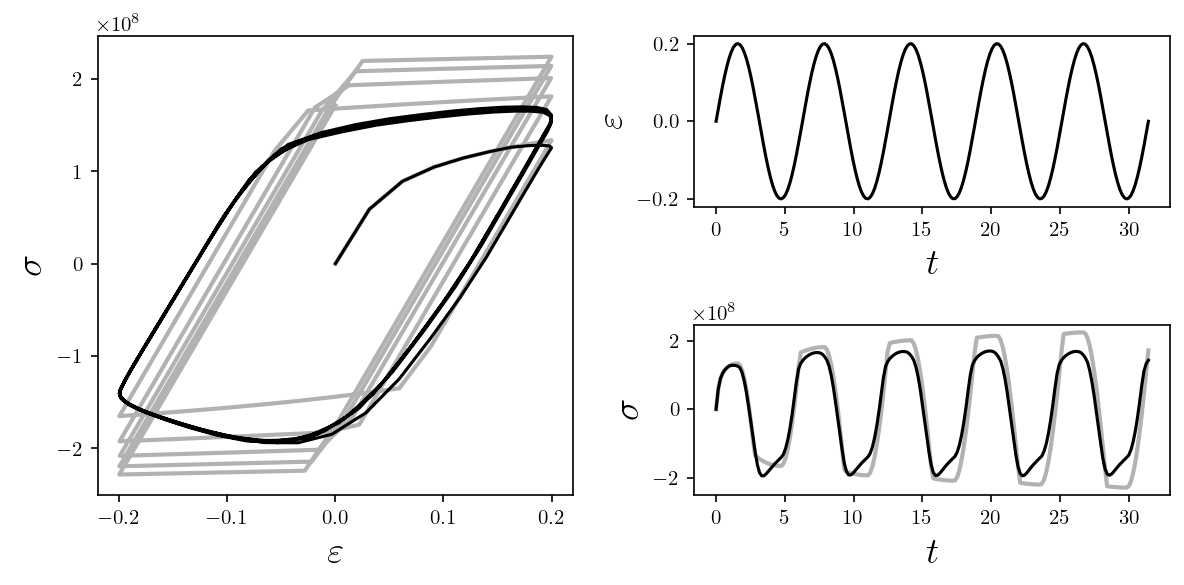

In [ ]:
N = 200
 
t = np.linspace(0, 10*np.pi, N)
eps = np.sin(t) * 0.2

mat = MATERIALS[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

# plot
plot_response(eps, sig_true, sig_pred, t)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'sin5_N={N}.png'))
plt.show()

100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


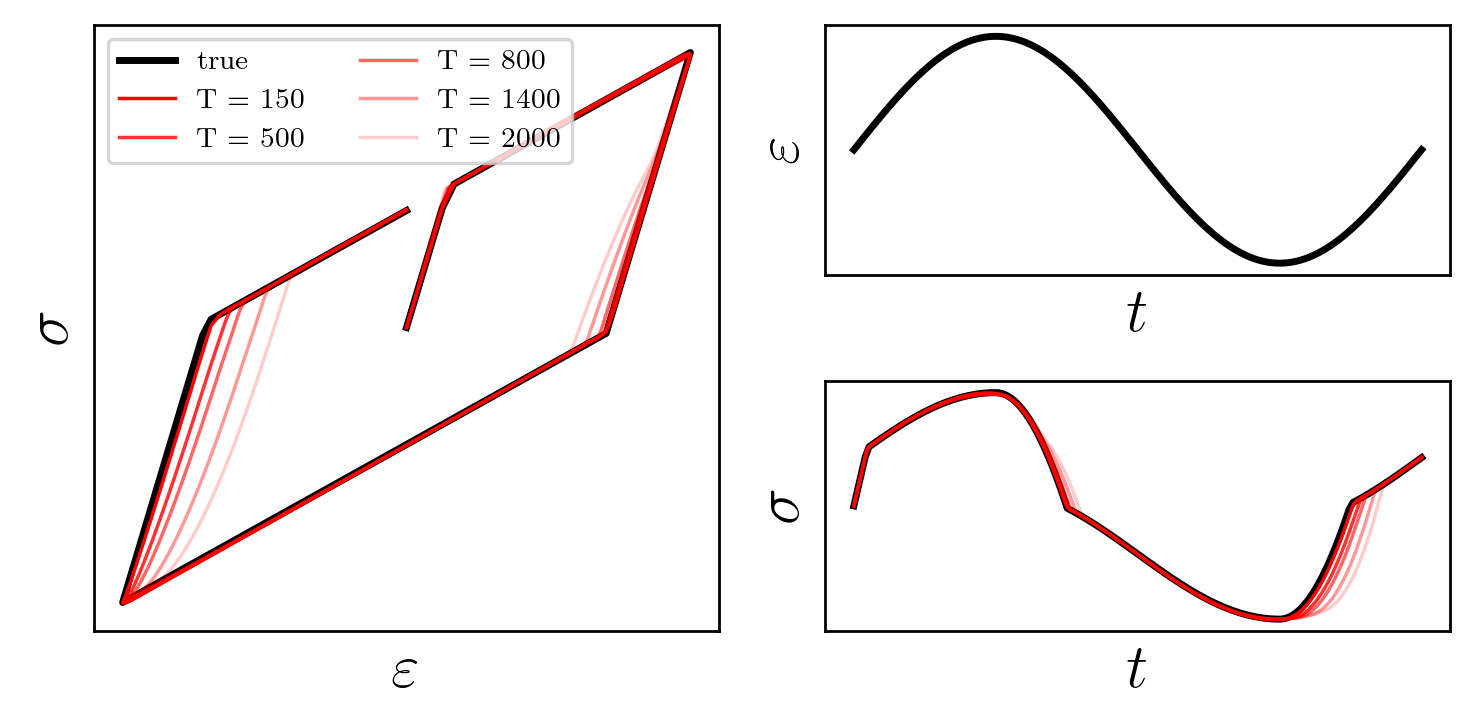

In [ ]:
fig = plt.figure(figsize=(6, 3),dpi=250)
gs = GridSpec(2, 2, height_ratios=[1, 1])
# fig.suptitle(r'', fontsize=18)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])



from tqdm import tqdm
flag = False
for N, alpha in tqdm([(150,1),(500,0.8),(800,0.6),(1400,0.4),(2000,0.2)]):

    t = np.linspace(0, 2*np.pi, N)
    eps = np.sin(t) * 0.2

    mat = MATERIALS[name]
    sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

    model = load_model(osp.join(model_path, 'model.pth'))
    y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
    u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
    sig_pred = model.predict(y0, u).detach().numpy()[0]

    if not flag:
        flag = True
        ax2.plot(t,eps,c='black',lw=2)
        ax1.plot(eps,sig_true,c='black',lw=2,label='true')
        ax3.plot(t,sig_true,c='black',lw=2)

    ax1.plot(eps,sig_pred,c='red',lw=1,alpha=alpha,label=f'T = {N}')
    ax3.plot(t,sig_pred,c='red',lw=1,alpha=alpha)

    for ax_i in [ax1,ax2,ax3]:
        ax_i.set_xticks([])  # Remove x-axis numbers
        ax_i.set_yticks([])
ax1.set_xlabel(r'$\varepsilon$', fontsize=18)
ax1.legend(loc='upper left', fontsize=8, ncol=2)
ax2.set_xlabel(r'$t$', fontsize=18)
ax3.set_xlabel(r'$t$', fontsize=18)
ax1.set_ylabel(r'$\sigma$', fontsize=18)
ax2.set_ylabel(r'$\varepsilon$', fontsize=18)
ax3.set_ylabel(r'$\sigma$', fontsize=18)
plt.tight_layout()
# plt.savefig(osp.join(model_path,f'more-points.png'))
plt.show()

In [20]:
np.save('data/bottlenecks/long.npy',eps.reshape(1,-1))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


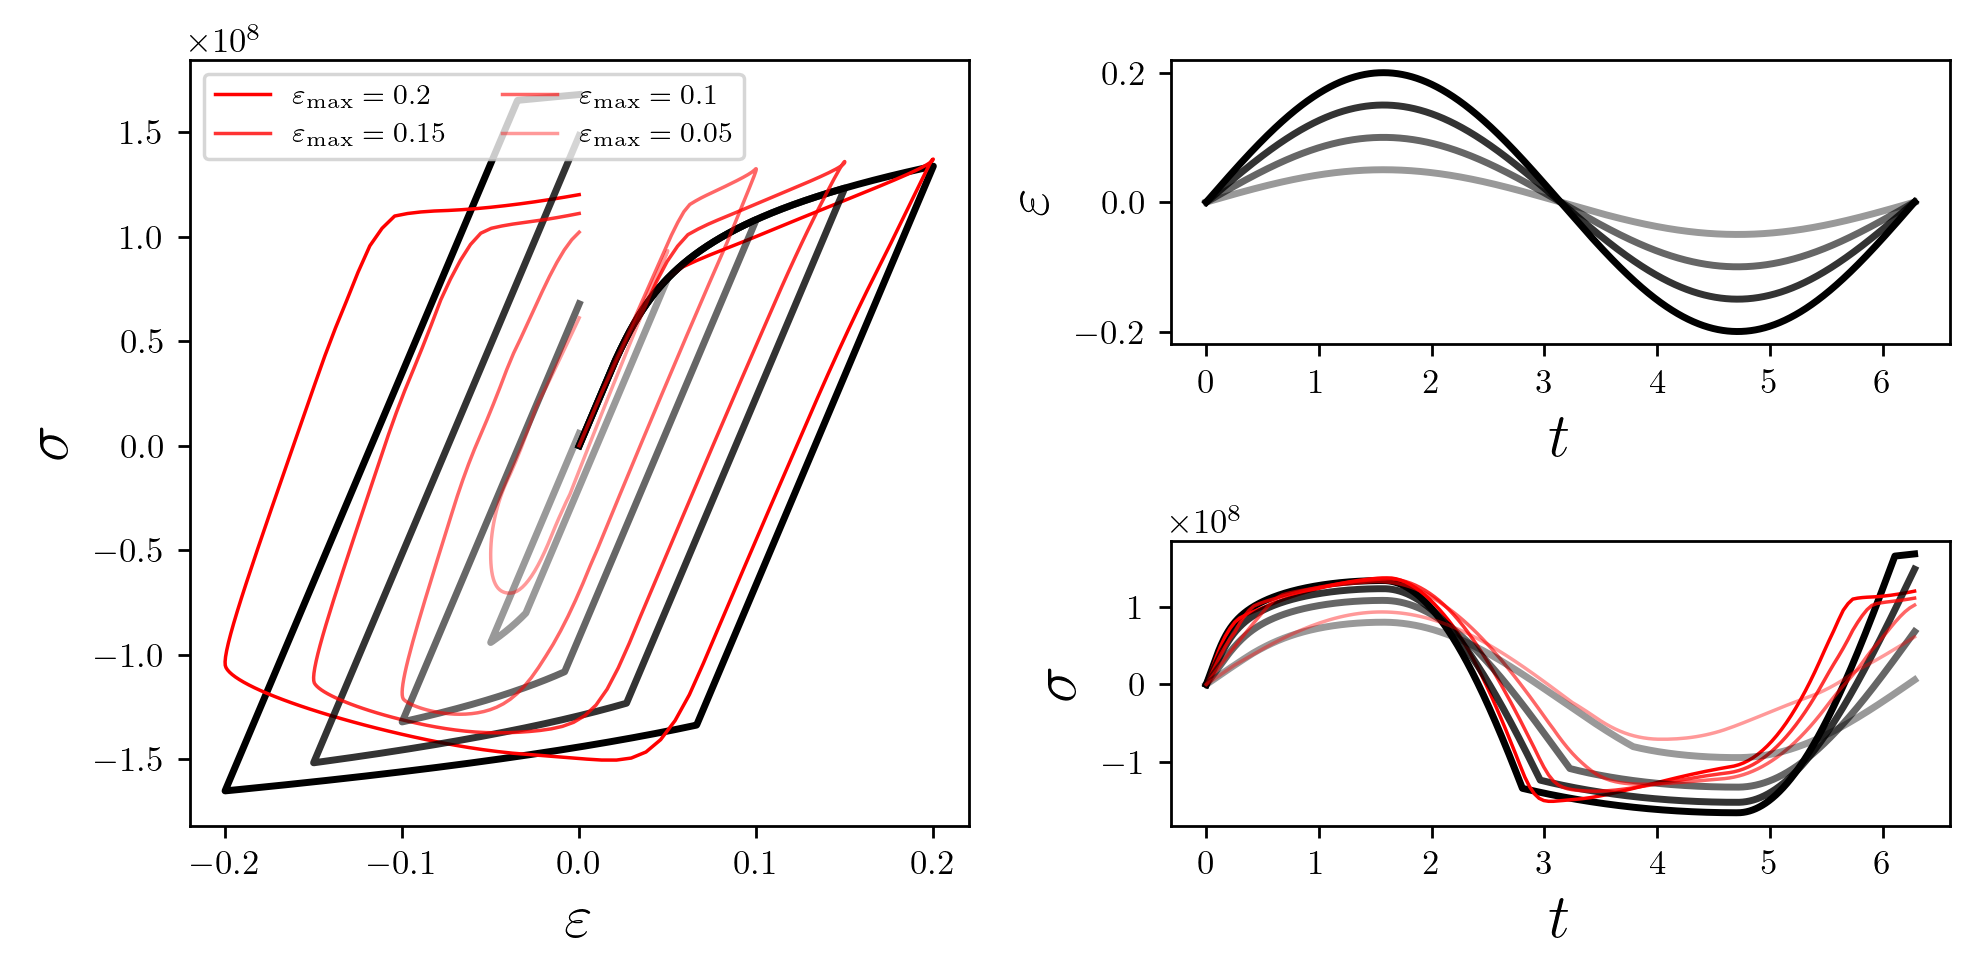

In [11]:
fig = plt.figure(figsize=(8, 4),dpi=250)
gs = GridSpec(2, 2, height_ratios=[1, 1])
# fig.suptitle(r'', fontsize=18)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])




from tqdm import tqdm
for eps_max, alpha in tqdm([(0.2,1),(0.15,0.8),(0.1,0.6),(0.05,0.4)]):

    N = 5000
    t = np.linspace(0, 2*np.pi, N)
    eps = np.sin(t) * eps_max
    sig_true = HARDENING(eps, MATERIALS[name]['E'],MATERIALS[name]['dalpha'], MATERIALS[name]['Y'])[0]
    
    ax2.plot(t,eps,c='black',lw=2,alpha=alpha)
    ax1.plot(eps,sig_true,c='black',lw=2,alpha=alpha)
    ax3.plot(t,sig_true,c='black',lw=2,alpha=alpha)

    N = 150
    t = np.linspace(0, 2*np.pi, N)
    eps = np.sin(t) * eps_max
    sig_true = HARDENING(eps, MATERIALS[name]['E'],MATERIALS[name]['dalpha'], MATERIALS[name]['Y'])[0]

    model = load_model(osp.join(model_path, 'model.pth'))
    y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
    u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
    sig_pred = model.predict(y0, u).detach().numpy()[0]

    ax1.plot(eps, sig_pred, c='red', lw=1, alpha=alpha, label=rf'$\varepsilon_{{\max}}={eps_max}$')
    ax3.plot(t,sig_pred,c='red',lw=1,alpha=alpha)



    #for ax_i in [ax1,ax2,ax3]:
    #    ax_i.set_xticks([])  # Remove x-axis numbers
    #    ax_i.set_yticks([])
ax1.set_xlabel(r'$\varepsilon$', fontsize=18)
ax1.legend(loc='upper left', fontsize=8, ncol=2)
ax2.set_xlabel(r'$t$', fontsize=18)
ax3.set_xlabel(r'$t$', fontsize=18)
ax1.set_ylabel(r'$\sigma$', fontsize=18)
ax2.set_ylabel(r'$\varepsilon$', fontsize=18)
ax3.set_ylabel(r'$\sigma$', fontsize=18)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'eps-scale.png'))
plt.show()

In [ ]:
np.save('data/bottlenecks/amplitude.npy',eps.reshape(1,-1))

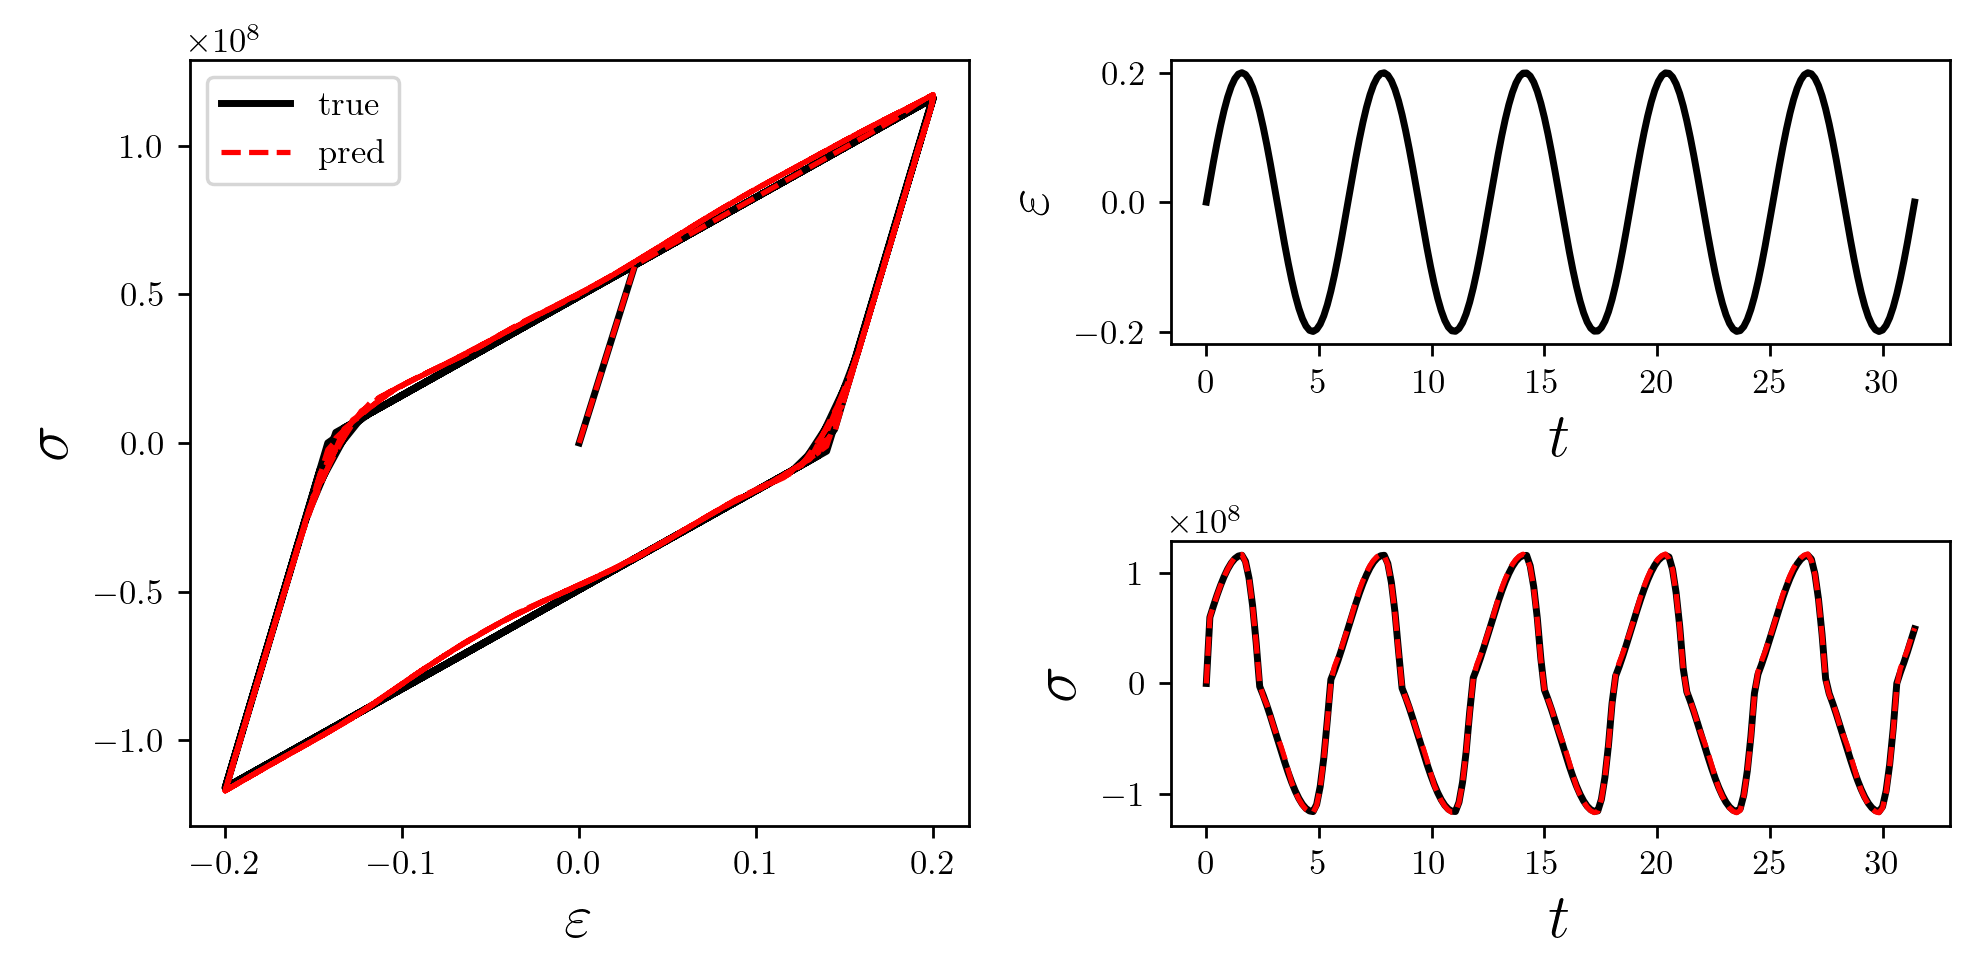

In [ ]:
N = 200

fig = plt.figure(figsize=(8, 4),dpi=250)
gs = GridSpec(2, 2, height_ratios=[1, 1])
# fig.suptitle(r'', fontsize=18)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

t = np.linspace(0, 10*np.pi, N)
eps = np.sin(t) * 0.2

mat = MATERIALS[name]
sig_true = HARDENING(eps, mat['E'],mat['dalpha'], mat['Y'])[0]

model = load_model(osp.join(model_path, 'model.pth'))
y0 = torch.tensor(sig_true[:k],dtype=torch.float).unsqueeze(0)
u = torch.tensor(eps,dtype=torch.float).unsqueeze(0)
sig_pred = model.predict(y0, u).detach().numpy()[0]

ax2.plot(t,eps,c='black',lw=2)
ax1.plot(eps,sig_true,c='black',lw=2,label='true')
ax3.plot(t,sig_true,c='black',lw=2)

ax1.plot(eps,sig_pred,c='red',lw=1.5,ls='--',label=f'pred')
ax3.plot(t,sig_pred,c='red',lw=1.5,ls='--')

#for ax_i in [ax1,ax2,ax3]:
#    ax_i.set_xticks([])  # Remove x-axis numbers
#    ax_i.set_yticks([])
ax1.set_xlabel(r'$\varepsilon$', fontsize=18)
ax1.legend(loc='upper left', fontsize=10)
ax2.set_xlabel(r'$t$', fontsize=18)
ax3.set_xlabel(r'$t$', fontsize=18)
ax1.set_ylabel(r'$\sigma$', fontsize=18)
ax2.set_ylabel(r'$\varepsilon$', fontsize=18)
ax3.set_ylabel(r'$\sigma$', fontsize=18)
plt.tight_layout()
plt.savefig(osp.join(model_path,f'more-unload.png'))
plt.show()

In [27]:
np.save('data/bottlenecks/cyclic.npy',eps.reshape(1,-1))